In [17]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import date_to_unix as date
import datetime

In [18]:

# Initialize the Binance client
client = Client()

In [19]:
# UNIX timestamp 
start_date = date.date_to_unix('2019-09-10 00:00:00')


In [20]:


# UNIX timestamp for today's midnight
today_midnight = datetime.datetime.combine(datetime.date.today(), datetime.time())

today_midnight_unix = date.date_to_unix(today_midnight.strftime('%Y-%m-%d %H:%M:%S'))

all_funding_df = pd.DataFrame()
funding_df=pd.DataFrame()
funding_rates = []

while True:
    # Query the futures funding rates
    funding_rates = client.futures_funding_rate(symbol='BTCUSDT', startTime = start_date, limit=1000)

    # Convert to DataFrame
    funding_df = pd.DataFrame(funding_rates)
    funding_df['fundingTime'] = pd.to_datetime(funding_df['fundingTime'], unit='ms').dt.round('s')
    funding_df.set_index('fundingTime', inplace=True)
    
    # Concatenate the newly fetched data with the accumulated data
    all_funding_df = pd.concat([all_funding_df, funding_df])

    # Get the last date in the fetched data
    last_date = funding_df.index[-1]

    if last_date >= pd.to_datetime(today_midnight_unix, unit='s'):
        break
    else:
        # Set start_date to the last fetched timestamp in UNIX format for the next query iteration
        start_date = int(last_date.timestamp() * 1000)  # Convert to milliseconds for Binance API

# You now have your data collected in funding_df up to today's midnight
print(all_funding_df)
print(funding_rates)

                      symbol fundingRate       markPrice
fundingTime                                             
2019-09-10 08:00:00  BTCUSDT  0.00010000                
2019-09-10 16:00:00  BTCUSDT  0.00010000                
2019-09-11 00:00:00  BTCUSDT  0.00010000                
2019-09-11 08:00:00  BTCUSDT  0.00010000                
2019-09-11 16:00:00  BTCUSDT  0.00010000                
...                      ...         ...             ...
2024-05-12 00:00:00  BTCUSDT  0.00002604  60809.20000000
2024-05-12 08:00:00  BTCUSDT  0.00002830  60804.40000000
2024-05-12 16:00:00  BTCUSDT  0.00010000  61395.90000000
2024-05-13 00:00:00  BTCUSDT  0.00010000  61455.70000000
2024-05-13 08:00:00  BTCUSDT  0.00008469  62307.64358156

[5127 rows x 3 columns]
[{'symbol': 'BTCUSDT', 'fundingTime': 1711958400000, 'fundingRate': '0.00033491', 'markPrice': '69636.12130851'}, {'symbol': 'BTCUSDT', 'fundingTime': 1711987200000, 'fundingRate': '0.00027469', 'markPrice': '68284.83075177'}, {'symbo

In [21]:
funding_df= all_funding_df

print(funding_df.shape)
print(funding_df.dtypes)

(5127, 3)
symbol         object
fundingRate    object
markPrice      object
dtype: object


In [22]:
#Give correct type
funding_df['fundingRate'] = funding_df['fundingRate'].astype(float)
funding_df['symbol'] = funding_df['symbol'].astype(str)
funding_df['markPrice'] = pd.to_numeric(funding_df['markPrice'], errors='coerce')
print(funding_df.head())
print(funding_df.tail())
print(funding_df.describe())


                      symbol  fundingRate  markPrice
fundingTime                                         
2019-09-10 08:00:00  BTCUSDT       0.0001        NaN
2019-09-10 16:00:00  BTCUSDT       0.0001        NaN
2019-09-11 00:00:00  BTCUSDT       0.0001        NaN
2019-09-11 08:00:00  BTCUSDT       0.0001        NaN
2019-09-11 16:00:00  BTCUSDT       0.0001        NaN
                      symbol  fundingRate     markPrice
fundingTime                                            
2024-05-12 00:00:00  BTCUSDT     0.000026  60809.200000
2024-05-12 08:00:00  BTCUSDT     0.000028  60804.400000
2024-05-12 16:00:00  BTCUSDT     0.000100  61395.900000
2024-05-13 00:00:00  BTCUSDT     0.000100  61455.700000
2024-05-13 08:00:00  BTCUSDT     0.000085  62307.643582
       fundingRate     markPrice
count  5127.000000    587.000000
mean      0.000134  51478.491547
std       0.000245  12219.309896
min      -0.003000  34149.463652
25%       0.000043  41971.459387
50%       0.000100  45766.400000
75%   

In [23]:
# Fetch historical price data for BTCUSDT spot and future
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))
klines_future= client.futures_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))

In [24]:
def klines_toDf(klines):
    """
    Convert list of klines to a pandas DataFrame.

    :param klines: A list of klines data.
    :type klines: list
    :return: A pandas DataFrame with columns ['Open Time', 'Open', 'Close', 'Volume'].
    :rtype: pandas.DataFrame
    """
    prices_df = pd.DataFrame(klines, columns=[
        'Open Time', 
        'Open', 
        'High', 
        'Low', 
        'Close', 
        'Volume', 
        'Close Time', 
        'Quote Asset Volume', 
        'Number of Trades', 
        'Taker Buy Base Asset Volume', 
        'Taker Buy Quote Asset Volume', 
        'Ignore'
    ])
    
    prices_df = prices_df[['Open Time', 'Open', 'Close', 'Volume']]
    
    # Convert time from milliseconds to a readable date format
    prices_df['Open Time'] = pd.to_datetime(prices_df['Open Time'], unit='ms')
    prices_df.set_index('Open Time', inplace=True)
    # Convert 'Open', 'Close', and 'Volume' to float
    prices_df['Open'] = prices_df['Open'].astype(float)
    prices_df['Close'] = prices_df['Close'].astype(float)
    prices_df['Volume'] = prices_df['Volume'].astype(float)
    
    # Now apply rounding
    prices_df = prices_df.round(decimals=4)
    
    # Check the changes
    print(prices_df.head())
    print(prices_df.tail())
    print(prices_df.dtypes)
    print(prices_df.shape)
    return prices_df

In [25]:
# Convert the spot and future kline data to dataframes
price_df_spot = klines_toDf(klines)
price_df_futur = klines_toDf(klines_future)

# Rename the 'Open' column in both dataframes for clarity
price_df_spot = price_df_spot.rename(columns={'Open': 'Open BTCUSDT_SPOT'})
price_df_futur = price_df_futur.rename(columns={'Open': 'Open BTCUSDT_PERP'})

# Concatenate the two dataframes along the column axis
prices_df = pd.concat([price_df_spot['Open BTCUSDT_SPOT'], price_df_futur['Open BTCUSDT_PERP']], axis=1)

# Display the resulting dataframe
prices_df

                         Open     Close      Volume
Open Time                                          
2019-09-10 08:00:00  10272.64  10175.07   8525.1546
2019-09-10 16:00:00  10176.26  10098.15  12837.4118
2019-09-11 00:00:00  10098.19  10066.00  13242.1083
2019-09-11 08:00:00  10066.38   9990.07   9300.9061
2019-09-11 16:00:00   9990.57  10158.33   9410.8103
                         Open     Close      Volume
Open Time                                          
2024-05-12 00:00:00  60825.99  60820.00   2681.0834
2024-05-12 08:00:00  60819.99  61419.00   4389.0723
2024-05-12 16:00:00  61419.01  61483.99   5682.9766
2024-05-13 00:00:00  61484.00  62334.37  10116.8510
2024-05-13 08:00:00  62334.36  62612.00   9595.2508
Open      float64
Close     float64
Volume    float64
dtype: object
(5122, 3)
                         Open     Close    Volume
Open Time                                        
2019-09-10 08:00:00  10271.93  10179.10  2938.811
2019-09-10 16:00:00  10172.13  10102.02  287

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP
Open Time,,
2019-09-10 08:00:00,10272.64,10271.93
2019-09-10 16:00:00,10176.26,10172.13
2019-09-11 00:00:00,10098.19,10094.27
2019-09-11 08:00:00,10066.38,10068.41
2019-09-11 16:00:00,9990.57,9992.18
...,...,...
2024-05-12 00:00:00,60825.99,60809.20
2024-05-12 08:00:00,60819.99,60803.80
2024-05-12 16:00:00,61419.01,61395.90


In [26]:
#Merge the prices with the funding and Mark price
data2 = pd.concat([prices_df,funding_df['fundingRate'],funding_df['markPrice']],axis=1)
data2['cumulative funding rate'] = data2['fundingRate'].cumsum()

In [27]:
data2.shape

(5127, 5)

In [28]:
data2.tail()


,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
2024-05-12 00:00:00,60825.99,60809.2,0.000026,60809.200000,0.688301
2024-05-12 08:00:00,60819.99,60803.8,0.000028,60804.400000,0.688329
2024-05-12 16:00:00,61419.01,61395.9,0.000100,61395.900000,0.688429
2024-05-13 00:00:00,61484.00,61455.7,0.000100,61455.700000,0.688529
2024-05-13 08:00:00,62334.36,62296.5,0.000085,62307.643582,0.688614


In [29]:
data2.describe()

,Open BTCUSDT_SPOT,Open BTCUSDT_PERP,fundingRate,markPrice,cumulative funding rate
count,5127.000000,5127.000000,5127.000000,587.000000,5127.000000
mean,29699.612284,29701.352600,0.000134,51478.491547,0.398805
std,17131.290395,17140.650982,0.000245,12219.309896,0.211779
min,4789.990000,4762.280000,-0.003000,34149.463652,0.000100
25%,15459.715000,15466.310000,0.000043,41971.459387,0.157096
50%,27510.930000,27497.400000,0.000100,45766.400000,0.504802
75%,42371.625000,42355.720000,0.000100,63914.730223,0.560051
max,73224.000000,73280.700000,0.003000,73280.700000,0.688614


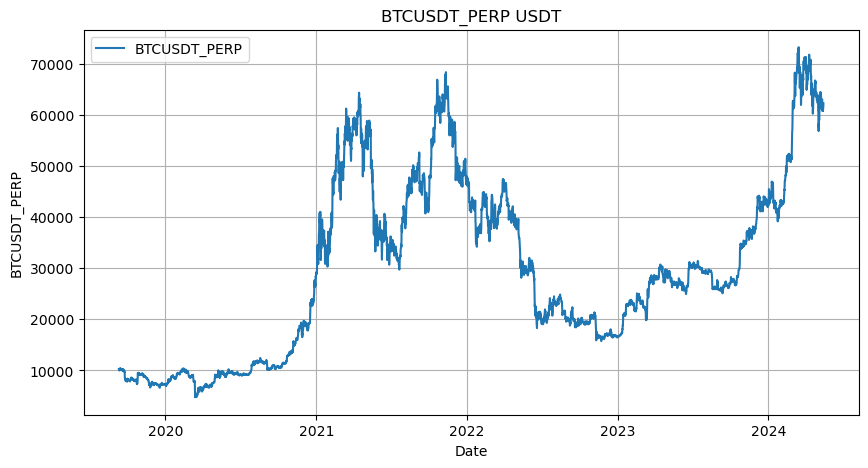

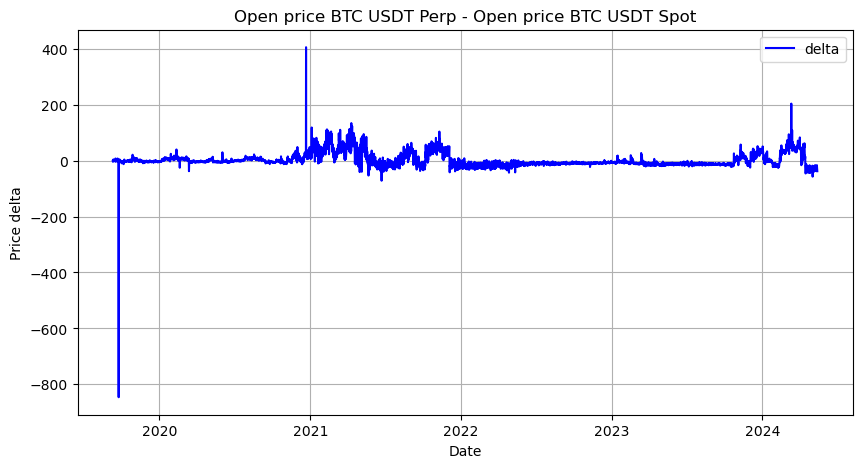

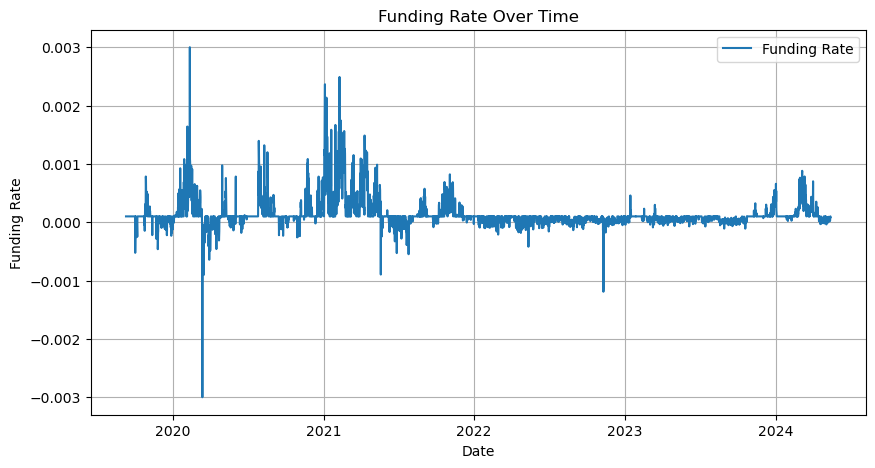

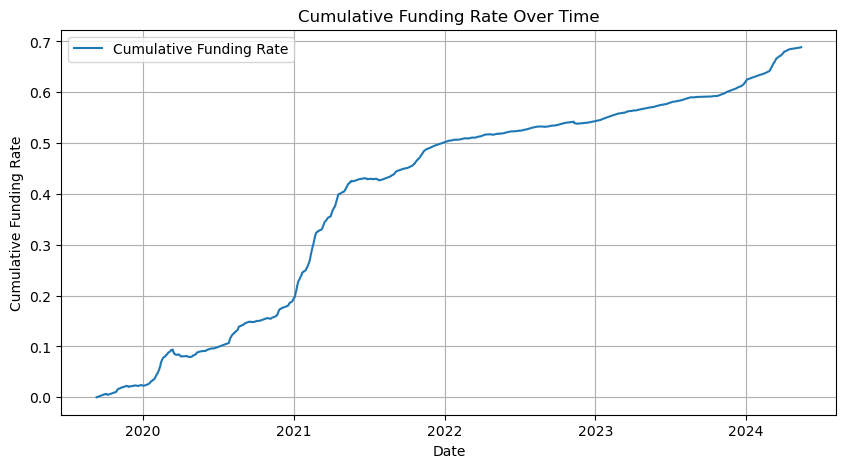

In [30]:
# Plotting BTCUSDT_PERP prices
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['Open BTCUSDT_PERP'],label = 'BTCUSDT_PERP')
plt.title('BTCUSDT_PERP USDT')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('BTCUSDT_PERP')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

#Plotting the price difference between Future and Spot on Binance perpetual 
plt.figure(figsize=(10, 5))
plt.plot(prices_df.index, prices_df['Open BTCUSDT_PERP']-prices_df['Open BTCUSDT_SPOT'], color='blue', label= 'delta')
plt.title('Open price BTC USDT Perp - Open price BTC USDT Spot')
plt.xlabel('Date')
plt.ylabel('Price delta')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['fundingRate'], label='Funding Rate')
plt.title('Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

# Plotting the cumulative funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['cumulative funding rate'], label='Cumulative Funding Rate')
plt.title('Cumulative Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Cumulative Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend
plt.show()  # Display the plot


In [31]:
data2.to_csv('data\Bitcoin 2019-09-10')